# SUPREME COURT JUDGMENT PREDICTION

#### EDA to predict verdict based on facts

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import missingno as msno
import os
import csv
import sys
import re
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

sb.set()
sb.set_style('darkgrid')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)



In [2]:
df = pd.read_csv("D:\Open Classroom\Datasets\Supreme Court Judgment Prediction\justice.csv")

In [3]:
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


#### Data Cleaning and Exploration

In [4]:
df.drop(columns = ["Unnamed: 0", "href"], inplace = True)

In [5]:
df.head()

,ID,name,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,50606,Roe v. Wade,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,50613,Stanley v. Illinois,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,50623,Giglio v. United States,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,50632,Reed v. Reed,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,50643,Miller v. California,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


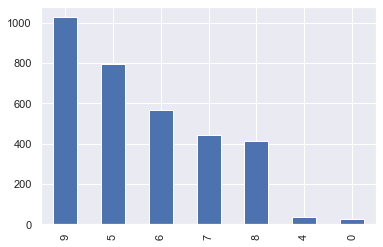

In [6]:
df['majority_vote'].value_counts().plot(kind = 'bar')

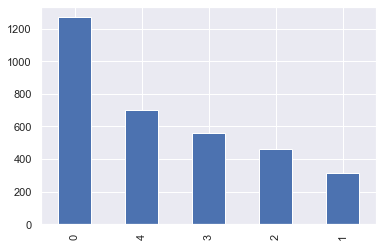

In [7]:
df['minority_vote'].value_counts().plot(kind = 'bar')

In [8]:
fpw = df['first_party_winner'].value_counts()
fpw

True     2140
False    1148
Name: first_party_winner, dtype: int64

([<matplotlib.patches.Wedge at 0x15a9af162e0>,
 [Text(-0.5020099413086101, 0.9787676020523596, 'True'),
  Text(0.5020100329474443, -0.9787675550507925, 'False')],
 [Text(-0.27382360435015096, 0.5338732374831051, '65.1%'),
  Text(0.2738236543349696, -0.5338732118458868, '34.9%')])

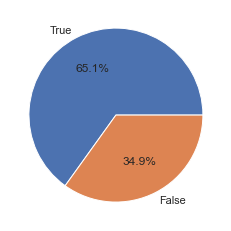

In [9]:
plt.pie(fpw, labels = fpw.index, autopct = '%0.1f%%')

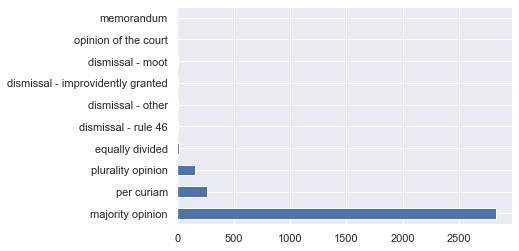

In [10]:
df['decision_type'].value_counts().plot(kind = 'barh')

In [11]:
df['disposition'].value_counts()

reversed/remanded            1073
affirmed                     1007
reversed                      585
vacated/remanded              430
reversed in-part/remanded      61
none                           41
reversed in-part               22
vacated                         7
vacated in-part/remanded        5
Name: disposition, dtype: int64

In [12]:
df['issue_area'].value_counts()

Criminal Procedure      859
Civil Rights            568
Economic Activity       542
First Amendment         353
Judicial Power          342
Due Process             128
Federalism              125
Privacy                  70
Unions                   60
Federal Taxation         51
Attorneys                37
Miscellaneous            20
Private Action            4
Interstate Relations      2
Name: issue_area, dtype: int64

In [13]:
df.isnull().sum()

ID                      0
name                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [14]:
features = [x for x in df.columns if df[x].isnull().sum() > 0]
features

['first_party',
 'second_party',
 'first_party_winner',
 'decision_type',
 'disposition',
 'issue_area']

In [15]:
for i in features:
    df[i] = df[i].fillna('None')

In [16]:
df.isnull().sum()

ID                    0
name                  0
docket                0
term                  0
first_party           0
second_party          0
facts                 0
facts_len             0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
dtype: int64

In [17]:
df2 = df.copy()

In [18]:
df2.drop(columns = ['ID','name','docket','term','first_party','second_party','facts_len','majority_vote','minority_vote',
                   'first_party_winner'], inplace = True)

In [19]:
df2.head()

,facts,decision_type,disposition,issue_area
0,"<p>In 1970, Jane Roe (a fictional name used in...",majority opinion,reversed,None
1,<p>Joan Stanley had three children with Peter ...,majority opinion,reversed/remanded,Civil Rights
2,<p>John Giglio was convicted of passing forged...,majority opinion,reversed/remanded,Due Process
3,"<p>The Idaho Probate Code specified that ""male...",majority opinion,reversed/remanded,Civil Rights
4,"<p>Miller, after conducting a mass mailing cam...",majority opinion,vacated/remanded,First Amendment


In [20]:
df2['facts'] = df['facts'].str.replace('<p>','')

In [21]:
df2.head()

,facts,decision_type,disposition,issue_area
0,"In 1970, Jane Roe (a fictional name used in co...",majority opinion,reversed,None
1,Joan Stanley had three children with Peter Sta...,majority opinion,reversed/remanded,Civil Rights
2,John Giglio was convicted of passing forged mo...,majority opinion,reversed/remanded,Due Process
3,"The Idaho Probate Code specified that ""males m...",majority opinion,reversed/remanded,Civil Rights
4,"Miller, after conducting a mass mailing campai...",majority opinion,vacated/remanded,First Amendment


## Feature Engineering
#### Perform One Hot Encoding

In [22]:
le = LabelEncoder()

In [23]:
df2['decision_num'] = le.fit_transform(df2['decision_type'])
df2['disposition_num'] = le.fit_transform(df2['disposition'])
df2['issue_num'] = le.fit_transform(df2['issue_area'])

In [24]:
df2.head()

,facts,decision_type,disposition,issue_area,decision_num,disposition_num,issue_num
0,"In 1970, Jane Roe (a fictional name used in co...",majority opinion,reversed,None,6,3,11
1,Joan Stanley had three children with Peter Sta...,majority opinion,reversed/remanded,Civil Rights,6,6,1
2,John Giglio was convicted of passing forged mo...,majority opinion,reversed/remanded,Due Process,6,6,3
3,"The Idaho Probate Code specified that ""males m...",majority opinion,reversed/remanded,Civil Rights,6,6,1
4,"Miller, after conducting a mass mailing campai...",majority opinion,vacated/remanded,First Amendment,6,9,7


In [25]:
df2[['decision_type', 'decision_num']].sample(frac = 1).head()

,decision_type,decision_num
2480,majority opinion,6
600,majority opinion,6
1650,majority opinion,6
2143,majority opinion,6
2190,per curiam,9


#### Working with the Decision Type Series

In [26]:
x = df2['facts']
y = df2['decision_num']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)



x_train (2642,)
x_test (661,)
y_train (2642,)
y_test (661,)


#### Vectorization

In [27]:
vect = CountVectorizer()
%time vect.fit_transform(x_train)

Wall time: 914 ms


<2642x18107 sparse matrix of type '<class 'numpy.int64'>'
	with 251671 stored elements in Compressed Sparse Row format>

In [28]:
x_train_vect = vect.fit_transform(x_train)
%timeit x_train_vect

47.7 ns ± 3.52 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [29]:
x_test_vect = vect.fit_transform(x_test)
%timeit x_test_vect
%time x_test_vect

49.1 ns ± 9.79 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
Wall time: 0 ns


<661x9091 sparse matrix of type '<class 'numpy.int64'>'
	with 63311 stored elements in Compressed Sparse Row format>

#### Build and Evaluate Model

In [30]:
dtc = DecisionTreeClassifier()

In [31]:
dtc.fit(x_train_vect, y_train)

DecisionTreeClassifier()

In [32]:
x_train_vect_pred = dtc.predict(x_train_vect)
print([i for i in x_train_vect_pred], end='')

[6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 10, 10, 10, 6, 6, 6, 6, 6, 6, 6, 9, 6, 10, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 6, 9, 6, 10, 6, 6, 6, 6, 6, 9, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 9, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 10, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 10, 6, 9, 6, 6, 6, 6, 6, 6, 9, 6, 10, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 6, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 10, 6, 6, 9, 6, 6,

In [33]:
score = accuracy_score(x_train_vect_pred, y_train)
score

1.0